In [1]:
%load_ext watermark


In [2]:
import os

from IPython.display import display
import pandas as pd
import polars as pl
import seaborn as sns
from teeplot import teeplot as tp


In [3]:
%watermark -diwmuv -iv


Last updated: 2025-07-20T19:29:38.501930+00:00

Python implementation: CPython
Python version       : 3.10.12
IPython version      : 7.31.1

Compiler    : GCC 11.4.0
OS          : Linux
Release     : 6.8.0-1030-azure
Machine     : x86_64
Processor   : x86_64
CPU cores   : 4
Architecture: 64bit

teeplot: 1.4.2
polars : 1.9.0
seaborn: 0.13.2
pandas : 2.2.3

Watermark: 2.4.3



In [4]:
teeplot_subdir = os.environ.get("NOTEBOOK_NAME", "2025-01-25-cpp-bench-memory-pico")
teeplot_subdir


'2025-01-25-cpp-bench-memory-pico'

## Prep Data


In [5]:
df = pl.concat(
    [
        pl.read_csv("https://osf.io/xz6p9/download"),
    ],
)
df = (
    df.cast(
        {
            "memory_bytes": pl.Int32,
            "num_items": pl.Int32,
            "num_sites": pl.Int32,
            "duration_s": pl.Float64,
            "replicate": pl.Int32,
        },
    )
    .with_columns(
        duration_per_item_ns=(
            pl.col("duration_s") * 1_000_000_000 / pl.col("num_items")
        )
    )
    .with_columns(
        algorithm=pl.col("algo_name").map_elements(
            {
                "control_ring_algo": "control: ringbuf",
                "control_throwaway_algo": "control: discard",
                "dstream.steady_algo": "dstream steady",
                "dstream.stretched_algo": "dstream stretched",
                "dstream.tilted_algo": "dstream tilted",
                "naive_steady_algo": "naive steady",
                "zhao_steady_algo": "zhao steady",
                "zhao_tilted_algo": "zhao tilted",
            }.__getitem__,
            return_dtype=str,
        )
    )
    .with_columns(
        pl.col("data_type").alias("data type"),
    )
)

display(df.describe()), display(df.head()), display(df.tail());


statistic,algo_name,data_type,compiler,memory_bytes,num_items,num_sites,replicate,duration_s,duration_per_item_ns,algorithm,data type
str,str,str,str,f64,f64,f64,f64,f64,f64,str,str
"""count""","""6720""","""6720""","""6720""",6720.0,6720.0,6720.0,6720.0,6720.0,6720.0,"""6720""","""6720"""
"""null_count""","""0""","""0""","""0""",0.0,0.0,0.0,0.0,0.0,0.0,"""0""","""0"""
"""mean""",null,null,null,2877.083333,370000.0,1360.0,9.5,0.965481,11522.174907,null,null
"""std""",null,null,null,5592.94208,447023.194664,1620.076101,5.76671,3.394304,68067.660554,null,null
"""min""","""control_ring_algo""","""bit""","""g++""",12.0,10000.0,64.0,0.0,0.000819,80.037,"""control: discard""","""bit"""
"""25%""",null,null,null,132.0,10000.0,256.0,5.0,0.013405,196.039,null,null
"""50%""",null,null,null,516.0,100000.0,1024.0,10.0,0.08019,1332.8,null,null
"""75%""",null,null,null,2072.0,1e6,1024.0,14.0,0.360941,1994.99,null,null
"""max""","""zhao_tilted_algo""","""word""","""g++""",32792.0,1e6,4096.0,19.0,31.923358,730000.4,"""zhao tilted""","""word"""


algo_name,data_type,compiler,memory_bytes,num_items,num_sites,replicate,duration_s,duration_per_item_ns,algorithm,data type
str,str,str,i32,i32,i32,i32,f64,f64,str,str
"""control_ring_algo""","""double word""","""g++""",16388,10000,4096,0,0.001646,164.6,"""control: ringbuf""","""double word"""
"""control_ring_algo""","""double word""","""g++""",16388,10000,4096,1,0.001623,162.3,"""control: ringbuf""","""double word"""
"""control_ring_algo""","""double word""","""g++""",16388,10000,4096,2,0.001632,163.2,"""control: ringbuf""","""double word"""
"""control_ring_algo""","""double word""","""g++""",16388,10000,4096,3,0.001686,168.6,"""control: ringbuf""","""double word"""
"""control_ring_algo""","""double word""","""g++""",16388,10000,4096,4,0.001687,168.7,"""control: ringbuf""","""double word"""


algo_name,data_type,compiler,memory_bytes,num_items,num_sites,replicate,duration_s,duration_per_item_ns,algorithm,data type
str,str,str,i32,i32,i32,i32,f64,f64,str,str
"""zhao_tilted_algo""","""bit""","""g++""",111,1000000,64,15,2.573098,2573.098,"""zhao tilted""","""bit"""
"""zhao_tilted_algo""","""bit""","""g++""",111,1000000,64,16,2.573174,2573.174,"""zhao tilted""","""bit"""
"""zhao_tilted_algo""","""bit""","""g++""",111,1000000,64,17,2.573104,2573.104,"""zhao tilted""","""bit"""
"""zhao_tilted_algo""","""bit""","""g++""",111,1000000,64,18,2.573108,2573.108,"""zhao tilted""","""bit"""
"""zhao_tilted_algo""","""bit""","""g++""",111,1000000,64,19,2.573104,2573.104,"""zhao tilted""","""bit"""


In [6]:
assert (df.group_by(
    ["num_items", "num_sites", "algorithm", "data type"],
).agg(
    pl.col("memory_bytes").n_unique(),
)["memory_bytes"] == 1).all()


## Plot


## Memory Use


teeplots/2025-01-25-cpp-bench-memory-pico/col=num-items+hue=algo-name+kind=line+palette=muted+row=data-type+viz=relplot+x=num-sites+y=memory-bytes+ext=.pdf
teeplots/2025-01-25-cpp-bench-memory-pico/col=num-items+hue=algo-name+kind=line+palette=muted+row=data-type+viz=relplot+x=num-sites+y=memory-bytes+ext=.png


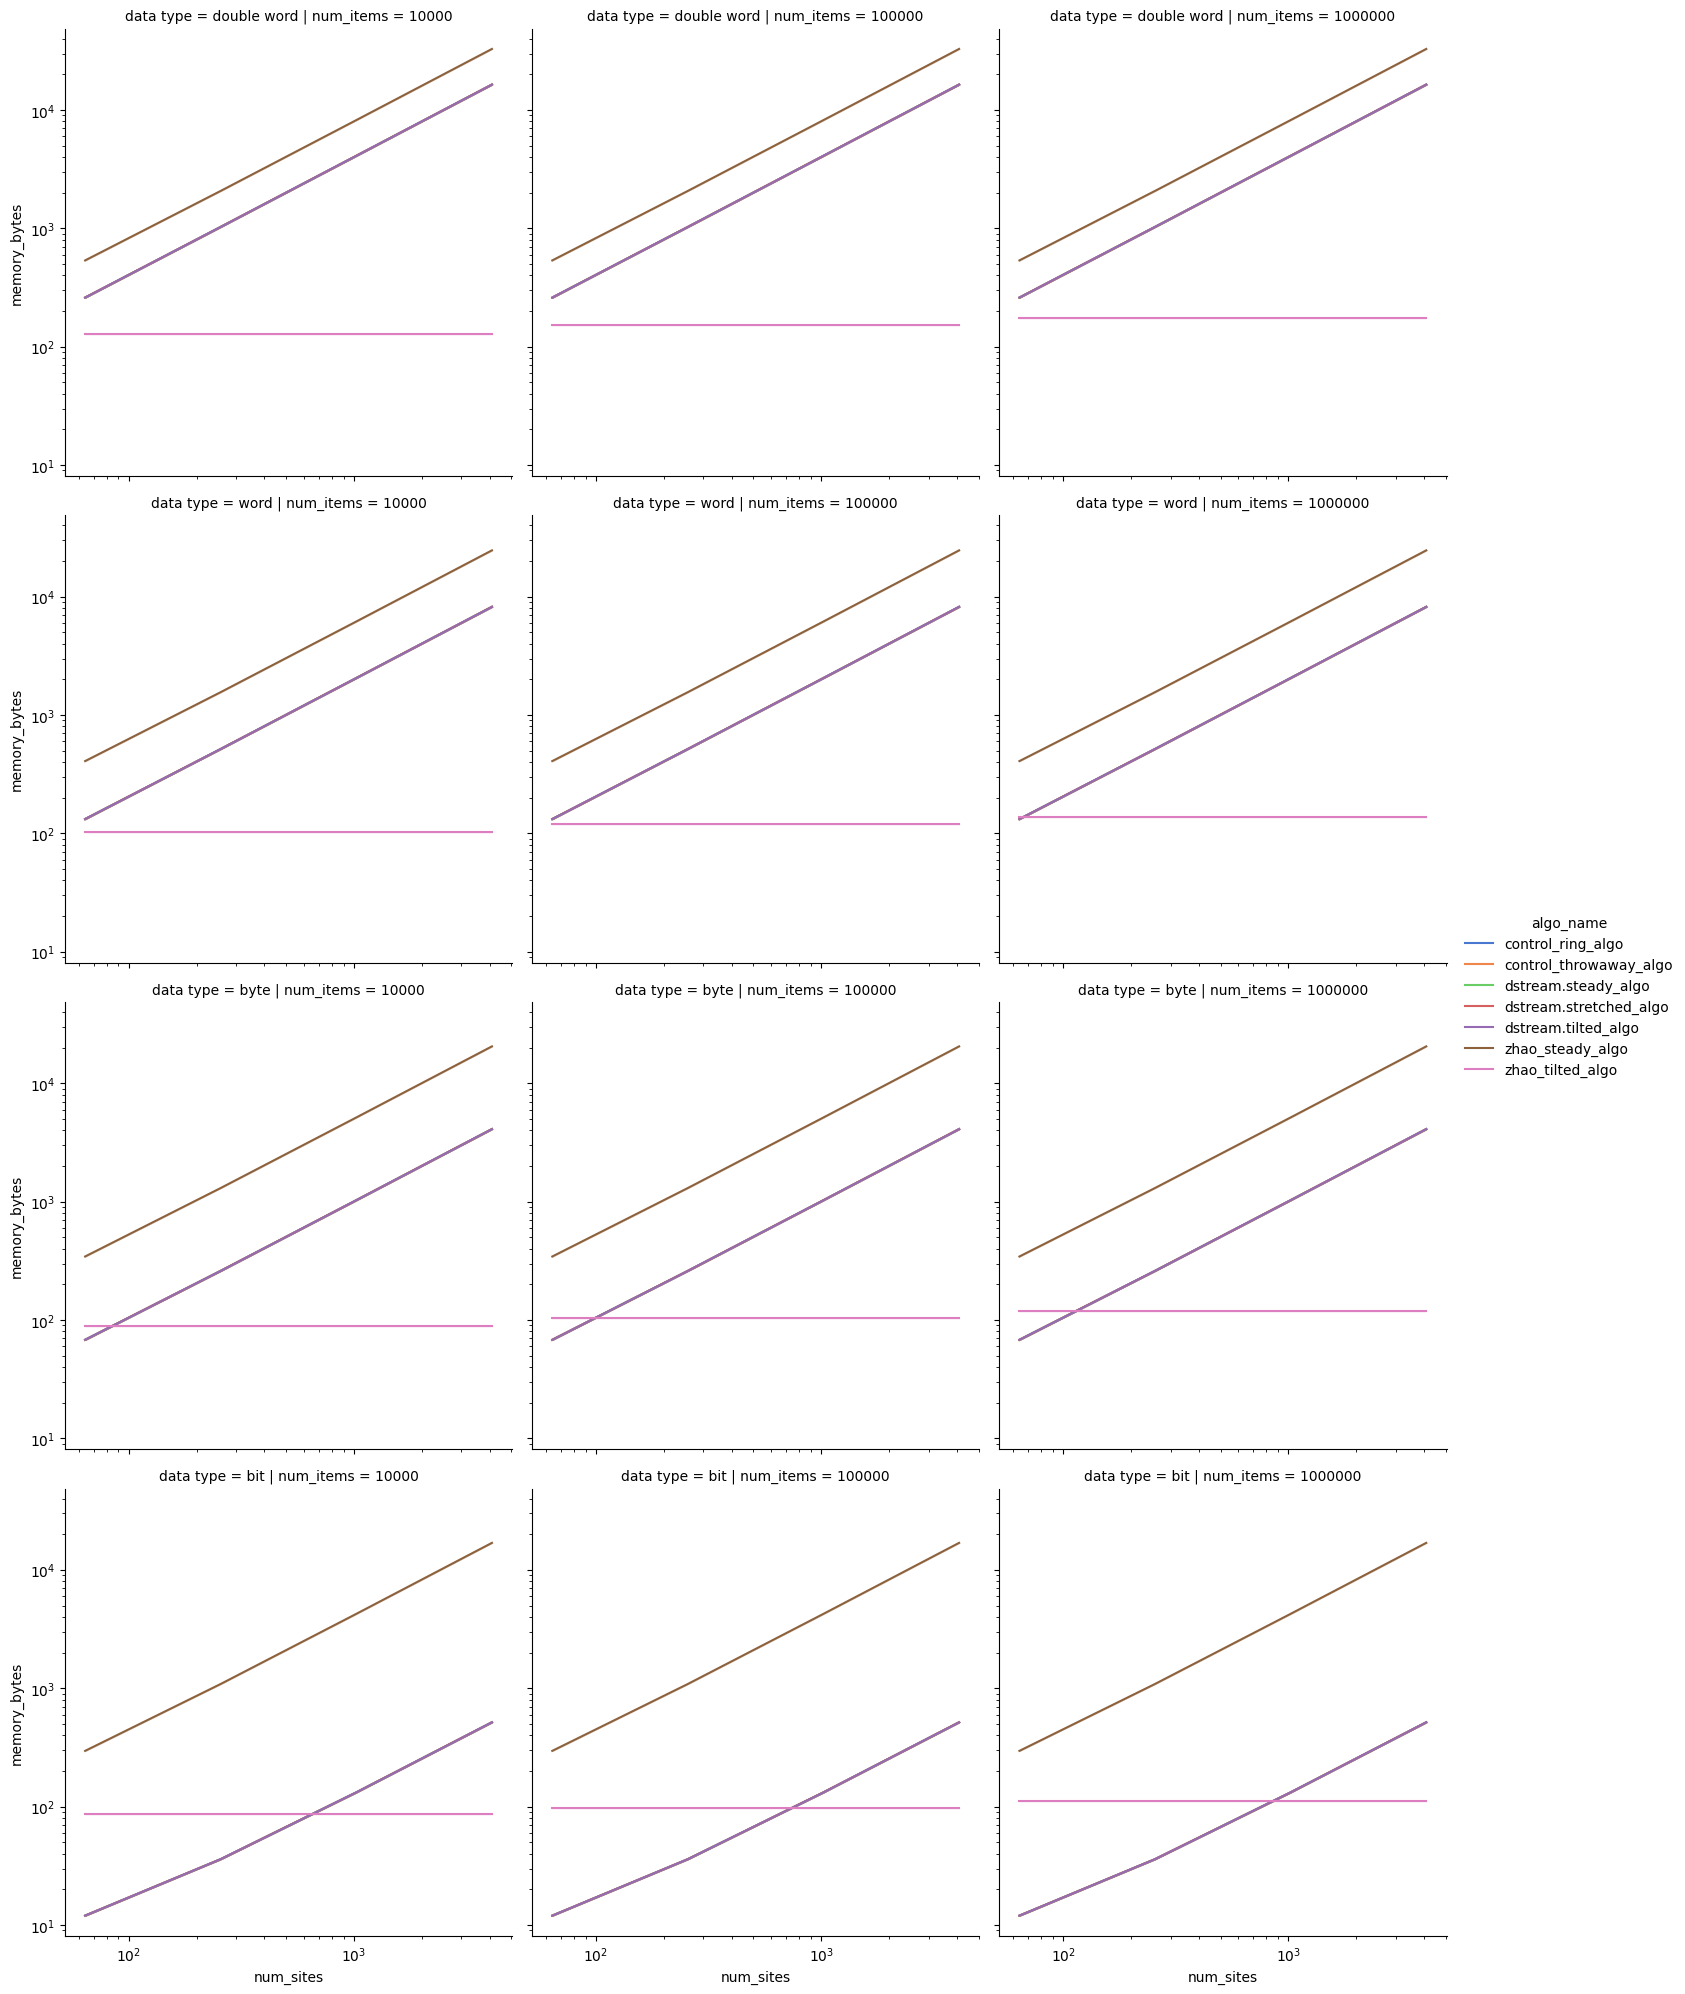

In [7]:
with tp.teed(
    sns.relplot,
    data=df,
    x="num_sites",
    y="memory_bytes",
    hue="algo_name",
    col="num_items",
    row="data type",
    palette="muted",
    kind="line",
    errorbar=("pi", 100),
    teeplot_subdir=teeplot_subdir,
) as g:
    g.set(xscale="log", yscale="log")


/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:44: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set(**kwargs)


teeplots/2025-01-25-cpp-bench-memory-pico/hue=strategy+kind=bar+palette=set2+viz=catplot+x=num-sites+y=memory-bytes+ext=.pdf
teeplots/2025-01-25-cpp-bench-memory-pico/hue=strategy+kind=bar+palette=set2+viz=catplot+x=num-sites+y=memory-bytes+ext=.png


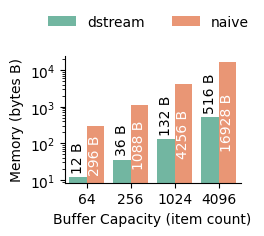

In [8]:
# Plot speedup
with tp.teed(
    sns.catplot,
    data=df.filter(
        pl.col("data type") == "bit"
    ).filter(
        pl.col("algo_name").is_in(
            [
                "dstream.steady_algo",
                "zhao_steady_algo",
            ],
        ),
    ).with_columns(
        strategy=pl.col("algo_name").map_elements(
            {
                "dstream.steady_algo": "dstream",
                "zhao_steady_algo": "naive",
            }.__getitem__,
            return_dtype=str,
        ),
    ),
    x="num_sites",
    y="memory_bytes",
    hue="strategy",
    kind="bar",
    aspect=1.5,
    height=2,
    errorbar=("pi", 100),
    palette="Set2",
    teeplot_subdir=teeplot_subdir,
) as g:
    g.set(yscale="log")
    g.set(ylim=(0, None))
    g.set_xlabels("Buffer Capacity (item count)")
    g.set_ylabels("Memory (bytes B)")
    for ax in g.axes.flat:
        ax.bar_label(
            ax.containers[0],
            fmt="%d B",
            label_type="edge",
            rotation=90,
            padding=3,
        )
        ax.bar_label(
            ax.containers[1],
            fmt="%d B",
            label_type="center",
            rotation=90,
            color="white",
        )
    sns.move_legend(
        g,
        "lower center",
        bbox_to_anchor=(0.5, 1),
        ncol=3,
        frameon=False,
        title=None,
    )


/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make Axes width small enough to accommodate all Axes decorations
  self._figure.tight_layout(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make Axes width small enough to accommodate all Axes decorations
  self._figure.tight_layout(*args, **kwargs)


teeplots/2025-01-25-cpp-bench-memory-pico/col=num-sites+hue=strategy+kind=bar+palette=set2+row=data-type+viz=catplot+y=memory-bytes+ext=.pdf
teeplots/2025-01-25-cpp-bench-memory-pico/col=num-sites+hue=strategy+kind=bar+palette=set2+row=data-type+viz=catplot+y=memory-bytes+ext=.png


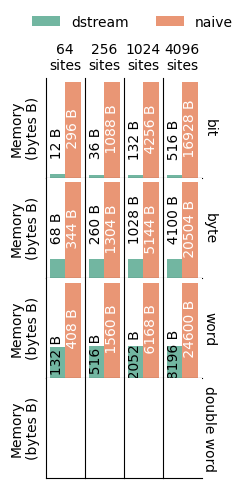

In [9]:
with tp.teed(
    sns.catplot,
    data=df.filter(
        pl.col("algo_name").is_in(
            [
                "dstream.steady_algo",
                "zhao_steady_algo",
            ],
        ),
    ).with_columns(
        pl.col("data type").str.replace_all(" ", "\n"),
        strategy=pl.col("algo_name").map_elements(
            {
                "dstream.steady_algo": "dstream",
                "zhao_steady_algo": "naive",
            }.__getitem__,
            return_dtype=str,
        ),
    ),
    col="num_sites",
    y="memory_bytes",
    hue="strategy",
    row="data type",
    row_order=["bit", "byte", "word", "double word"],
    kind="bar",
    errorbar=("pi", 100),
    margin_titles=True,
    aspect=0.4,
    height=1.3,
    palette="Set2",
    sharey=False,
    teeplot_subdir=teeplot_subdir,
) as g:
    # g.set(yscale="log")
    g.fig.subplots_adjust(wspace=0, hspace=0)
    g.set(ylim=(0, None))
    # g.set_xlabels("Buffer Capacity (item count)")
    g.set_titles(row_template="{row_name}", col_template="{col_name}\nsites")
    g.set_ylabels("Memory\n(bytes B)")
    for row, axs in enumerate(g.axes):
        for col, ax in enumerate(axs):
            ax.bar_label(
                ax.containers[0],
                fmt="  %d B",
                label_type="edge" if row < 2 else "center",
                rotation=90,
                padding=5 if row < 2 else 3 if row < 3 else -2,
            )
            ax.bar_label(
                ax.containers[1],
                fmt=" %d B",
                label_type="center",
                rotation=90,
                color="white",
            )
    sns.move_legend(
        g,
        "lower center",
        bbox_to_anchor=(0.4, 0.95),
        ncol=3,
        frameon=False,
        title=None,
    )
    g.set(yticks=[], xticks=[])


/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)


teeplots/2025-01-25-cpp-bench-memory-pico/col=data-type+exclude=+hue=strategy+kind=bar+palette=set2+row=num-sites+viz=catplot+x=memory-bytes+ext=.pdf
teeplots/2025-01-25-cpp-bench-memory-pico/col=data-type+exclude=+hue=strategy+kind=bar+palette=set2+row=num-sites+viz=catplot+x=memory-bytes+ext=.png


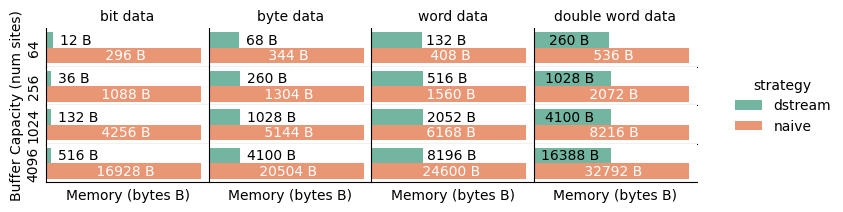

/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)


teeplots/2025-01-25-cpp-bench-memory-pico/col=data-type+exclude=bit,byte+hue=strategy+kind=bar+palette=set2+row=num-sites+viz=catplot+x=memory-bytes+ext=.pdf
teeplots/2025-01-25-cpp-bench-memory-pico/col=data-type+exclude=bit,byte+hue=strategy+kind=bar+palette=set2+row=num-sites+viz=catplot+x=memory-bytes+ext=.png


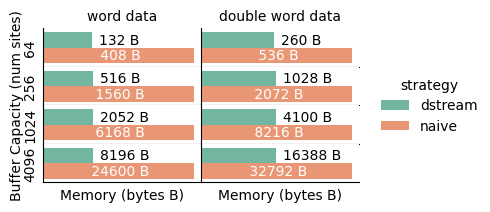

/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)


teeplots/2025-01-25-cpp-bench-memory-pico/col=data-type+exclude=word,double word+hue=strategy+kind=bar+palette=set2+row=num-sites+viz=catplot+x=memory-bytes+ext=.pdf
teeplots/2025-01-25-cpp-bench-memory-pico/col=data-type+exclude=word,double word+hue=strategy+kind=bar+palette=set2+row=num-sites+viz=catplot+x=memory-bytes+ext=.png


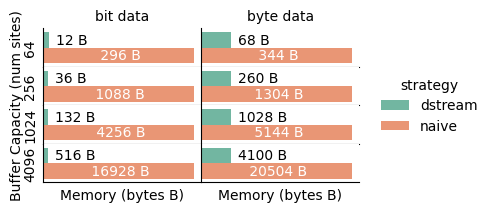

In [10]:
# Plot speedup
for exclude in "", "bit,byte", "word,double word":
    with tp.teed(
        sns.catplot,
        data=df.filter(
            pl.col("algo_name").is_in(
                [
                    "dstream.steady_algo",
                    "zhao_steady_algo",
                ],
            ),
        ).filter(
            ~pl.col("data type").is_in(exclude.split(",")),
        ).with_columns(
            strategy=pl.col("algo_name").map_elements(
                {
                    "dstream.steady_algo": "dstream",
                    "zhao_steady_algo": "naive",
                }.__getitem__,
                return_dtype=str,
            ),
        ),
        row="num_sites",
        x="memory_bytes",
        hue="strategy",
        col="data type",
        col_order=[
            x for x in
            ["bit", "byte", "word", "double word"]
            if x not in exclude.split(",")
        ],
        kind="bar",
        errorbar=("pi", 100),
        margin_titles=True,
        aspect=4,
        height=0.5,
        palette="Set2",
        sharex=False,
        teeplot_outattrs={"exclude": exclude},
        teeplot_subdir=teeplot_subdir,
    ) as g:
        # g.set(yscale="log")
        g.fig.subplots_adjust(wspace=0, hspace=0)
        g.set(xlim=(0, None))
        # g.set_xlabels("Buffer Capacity (item count)")
        g.set_titles(
            col_template="{col_name} data", row_template=""
        )
        g.set_xlabels("Memory (bytes B)")
        g.axes[0][0].set(ylabel="64")
        g.axes[1][0].set(ylabel="256")
        g.axes[2][0].set(ylabel="1024")
        g.axes[3][0].set(ylabel="4096")
        for row, axs in enumerate(g.axes):
            for col, ax in enumerate(axs):
                ax.bar_label(
                    ax.containers[0],
                    fmt="%d B",
                    label_type="edge" if col < 3 else "center",
                    rotation=0,
                    padding=5 if col < 2 else 3 if col < 3 else -2,
                )
                ax.bar_label(
                    ax.containers[1],
                    fmt=" %d B",
                    label_type="center",
                    rotation=0,
                    color="white",
                )
        supy_offset = 0.085 if not exclude else 0.06
        g.fig.supylabel(
            "Buffer Capacity (num sites)", fontsize="medium", x=supy_offset
        )
        g.set(yticks=[], xticks=[])


## relative memory savings


,num_sites,num_items,replicate,data type,memory_savings
0,64,370000.0,9.5,None,NaN
1,4096,370000.0,9.5,None,NaN
2,1024,370000.0,9.5,None,NaN
3,256,370000.0,9.5,None,NaN


teeplots/2025-01-25-cpp-bench-memory-pico/kind=bar+viz=catplot+x=num-sites+y=memory-savings+ext=.pdf
teeplots/2025-01-25-cpp-bench-memory-pico/kind=bar+viz=catplot+x=num-sites+y=memory-savings+ext=.png


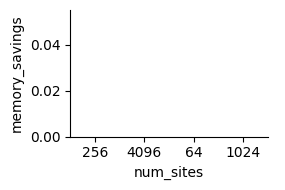

In [11]:
df_memory_savings = (
    df.filter(
        pl.col("algo_name").is_in(["dstream.steady_algo", "naive_steady_algo"])
    )
    .group_by(["num_items", "num_sites", "replicate", "data type"])
    .agg(
        memory_savings=(
            pl.col("memory_bytes")
            .filter(pl.col("algo_name") == "naive_steady_algo")
            .mean()
            / pl.col("memory_bytes")
            .filter(pl.col("algo_name") == "dstream.steady_algo")
            .mean()
        )
    )
)
with pd.option_context("display.max_columns", None):
    with pd.option_context("display.max_rows", None):
        display(df_memory_savings.group_by(["num_sites"]).mean().to_pandas())


# Plot savings
with tp.teed(
    sns.catplot,
    data=df_memory_savings.cast({"num_sites": str}),
    x="num_sites",
    y="memory_savings",
    kind="bar",
    aspect=1.5,
    height=2,
    teeplot_subdir=teeplot_subdir,
) as g:
    g.set(ylim=(0, None))
    for ax in g.axes.flat:
        ax.bar_label(ax.containers[0], fmt="$%d\\times$")


## absolute memory savings


teeplots/2025-01-25-cpp-bench-memory-pico/kind=bar+viz=catplot+x=num-sites+y=memory-savings+ext=.pdf
teeplots/2025-01-25-cpp-bench-memory-pico/kind=bar+viz=catplot+x=num-sites+y=memory-savings+ext=.png


/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:324: UserWarning: teeplot already created file teeplots/2025-01-25-cpp-bench-memory-pico/kind=bar+viz=catplot+x=num-sites+y=memory-savings+ext=.pdf, overwriting it
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:324: UserWarning: teeplot already created file teeplots/2025-01-25-cpp-bench-memory-pico/kind=bar+viz=catplot+x=num-sites+y=memory-savings+ext=.png, overwriting it
  warnings.warn(


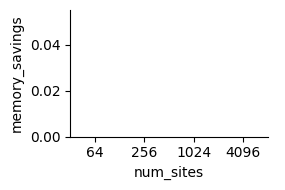

In [12]:
df_memory_savings = (
    df.filter(
        pl.col("algo_name").is_in(["dstream.steady_algo", "naive_steady_algo"])
    )
    .group_by(["num_items", "num_sites", "replicate"])
    .agg(
        memory_savings=(
            pl.col("memory_bytes")
            .filter(pl.col("algo_name") == "naive_steady_algo")
            .mean()
            - pl.col("memory_bytes")
            .filter(pl.col("algo_name") == "dstream.steady_algo")
            .mean()
        )
    )
)

# Plot savings
with tp.teed(
    sns.catplot,
    data=df_memory_savings.cast({"num_sites": str}),
    x="num_sites",
    y="memory_savings",
    kind="bar",
    aspect=1.5,
    height=2,
    teeplot_subdir=teeplot_subdir,
) as g:
    g.set(ylim=(0, None))
    for ax in g.axes.flat:
        ax.bar_label(ax.containers[0], fmt="%d B")
